In [2]:
import cv2
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from skimage.feature import hog, local_binary_pattern
from tensorflow.keras.models import Model
from google.colab.patches import cv2_imshow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, BatchNormalization,\
MaxPooling2D, UpSampling2D, concatenate, Input
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def load_data():
  digits = datasets.load_digits()
  images = digits.images
  labels = digits.target
  return digits, images, labels

In [4]:
def get_lbp_features(images):
  lbp_features = []
  for image in images:
      lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
      hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10 + 1), range=[0, 10])
      lbp_features.append(hist)
  lbp_features = np.array(lbp_features)
  return lbp_features

In [5]:
def get_mean_pixel_features(images):
  features = []
  for img in images:
    mean_pixel_values = np.mean(img, axis=(0, 1))
    features.append(mean_pixel_values)
  features = np.array(features)
  return features.reshape(len(features), 1)

In [6]:
def get_hog_features(images):
  hog_features = []
  for image in images:
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize=True)
    hog_features.append(fd)
  hog_features = np.array(hog_features)
  return hog_features

In [7]:
def get_fft_features(images):
  fft_features = []
  for image in images:
    fft_result = np.fft.fft2(image)
    fft_result = np.fft.fftshift(fft_result)
    magnitude_spectrum = np.abs(fft_result)
    fft_features.append(magnitude_spectrum.flatten())
  return np.array(fft_features)

In [8]:
def get_unet_model(input_shape):
  inputs = Input(shape=input_shape)

  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  up1 = UpSampling2D(size=(2, 2))(pool2)
  concat1 = concatenate([conv2, up1], axis=-1)
  conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat1)
  up2 = UpSampling2D(size=(2, 2))(conv3)
  concat2 = concatenate([conv1, up2], axis=-1)
  conv4 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(concat2)

  model = Model(inputs=inputs, outputs=conv4)
  return model

def get_unet_features(images):
  resized_images = np.array([cv2.resize(image, (32, 32)) for image in images])
  resized_images = np.repeat(resized_images[:, :, :, np.newaxis], 3, axis=-1)
  unet_model = get_unet_model((32, 32, 3))
  unet_features = unet_model.predict(resized_images)
  unet_features_flat = unet_features.reshape((len(unet_features), -1))
  return unet_features_flat

In [9]:
def neural_model():
  nn_model = Sequential()
  nn_model.add(Dense(32, activation='relu'))
  nn_model.add(Dropout(0.2))
  nn_model.add(BatchNormalization())
  nn_model.add(Dense(128, activation='relu'))
  nn_model.add(Dropout(0.2))
  nn_model.add(BatchNormalization())
  nn_model.add(Dense(64, activation='relu'))
  nn_model.add(Dropout(0.2))
  nn_model.add(BatchNormalization())
  nn_model.add(Dense(10, activation='softmax'))
  nn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return nn_model

In [10]:
def split_data(X, y, test_size):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
  return X_train, X_test, y_train, y_test

In [14]:
def run_classifier(model, X, y, is_neural=False):
  X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2)
  if is_neural:
    model.fit(X_train, y_train, epochs=50)
  else:
    model.fit(X_train, y_train)
  return model.evaluate(X_test, y_test)[1] if is_neural else model.score(X_test, y_test)

In [15]:
def get_feature_extractor(name, images):
  match name:
    case 'Mean': return get_mean_pixel_features(images)
    case 'LBP': return get_lbp_features(images)
    case 'HOG': return get_hog_features(images)
    case 'FFT': return get_fft_features(images)
    case 'U-Net': return get_unet_features(images)

In [16]:
def get_classifier(name):
  match name:
    case 'K-Nearest Neighbors': return KNeighborsClassifier(n_neighbors=6)
    case 'Support Vector Machine': return SVC(kernel='rbf')
    case 'Random Forest': return RandomForestClassifier(n_estimators=100)
    case 'Decision Tree': return DecisionTreeClassifier()
    case 'Neural Network': return neural_model()

In [17]:
def driver():
  feature_extraction_methods = ['Mean', 'LBP', 'HOG', 'FFT', 'U-Net']
  classifiers = ['Support Vector Machine', 'Random Forest', 'Decision Tree', 'K-Nearest Neighbors', 'Neural Network']
  accuracy_matrix = []
  digits, images, labels = load_data()

  for classifier in classifiers:
    accuracy_list = []
    for ex_method in feature_extraction_methods:
      print(ex_method)
      accuracy_list.append(run_classifier(get_classifier(classifier), get_feature_extractor(ex_method, images), labels, is_neural=(classifier == 'Neural Network')))
    accuracy_matrix.append(accuracy_list)
  accuracy_df = pd.DataFrame(accuracy_matrix, columns=feature_extraction_methods)
  accuracy_df.index = classifiers
  return accuracy_df

In [18]:
accuracy_df = driver()

Mean
LBP
HOG
FFT
U-Net
57/57 [==============================] - 2s 36ms/step
Mean
LBP
HOG
FFT
U-Net
57/57 [==============================] - 3s 48ms/step
Mean
LBP
HOG
FFT
U-Net
57/57 [==============================] - 2s 35ms/step
Mean
LBP
HOG
FFT
U-Net
57/57 [==============================] - 3s 49ms/step
Mean
Epoch 1/50
45/45 [==============================] - 2s 3ms/step - loss: 2.8457 - accuracy: 0.1079
Epoch 2/50
45/45 [==============================] - 0s 3ms/step - loss: 2.6820 - accuracy: 0.0905
Epoch 3/50
45/45 [==============================] - 0s 3ms/step - loss: 2.5937 - accuracy: 0.1106
Epoch 4/50
45/45 [==============================] - 0s 3ms/step - loss: 2.5362 - accuracy: 0.1079
Epoch 5/50
45/45 [==============================] - 0s 3ms/step - loss: 2.5441 - accuracy: 0.0960
Epoch 6/50
45/45 [==============================] - 0s 3ms/step - loss: 2.4845 - accuracy: 0.1169
Epoch 7/50
45/45 [==============================] - 0s 3ms/step - loss: 2.4924 - accuracy: 0.1093
E

In [27]:
accuracy_df = accuracy_df.reset_index()

In [29]:
accuracy_df.rename(columns={"index": "Classifier"}, inplace=True)

In [30]:
accuracy_df

,Classifier,Mean,LBP,HOG,FFT,U-Net
0,Support Vector Machine,0.130556,0.386111,0.847222,0.916667,0.961111
1,Random Forest,0.108333,0.311111,0.825000,0.925000,0.988889
2,Decision Tree,0.091667,0.236111,0.580556,0.744444,0.922222
3,K-Nearest Neighbors,0.080556,0.294444,0.800000,0.933333,0.941667
4,Neural Network,0.111111,0.372222,0.777778,0.911111,0.933333


In [41]:
def plot_standard(acc_data):
  plt.rcParams['figure.figsize'] = (10.0, 7.0)
  plt.style.use('ggplot')
  plt.plot(acc_data['Classifier'], acc_data.drop('Classifier', axis=1), '--o')
  plt.legend(acc_data.drop('Classifier', axis=1).columns)
  plt.show()

def plot_bar(acc_data):
  x = np.arange(len(acc_data['Classifier']))
  width = 0.12
  multiplier = 2
  _, ax = plt.subplots(layout='constrained', figsize=(16, 6))

  for attribute, measurement in acc_data.drop('Classifier', axis=1).items():
      offset = width * multiplier
      rects = ax.bar(x + offset, measurement.round(3), width, label=attribute)
      ax.bar_label(rects, padding=3)
      multiplier += 1

  ax.set_ylabel('Accuracy')
  ax.set_xticks(x + width + 0.36, acc_data['Classifier'])
  ax.legend(loc='lower right', ncols=3)
  ax.set_ylim(0, 1)

  plt.show()

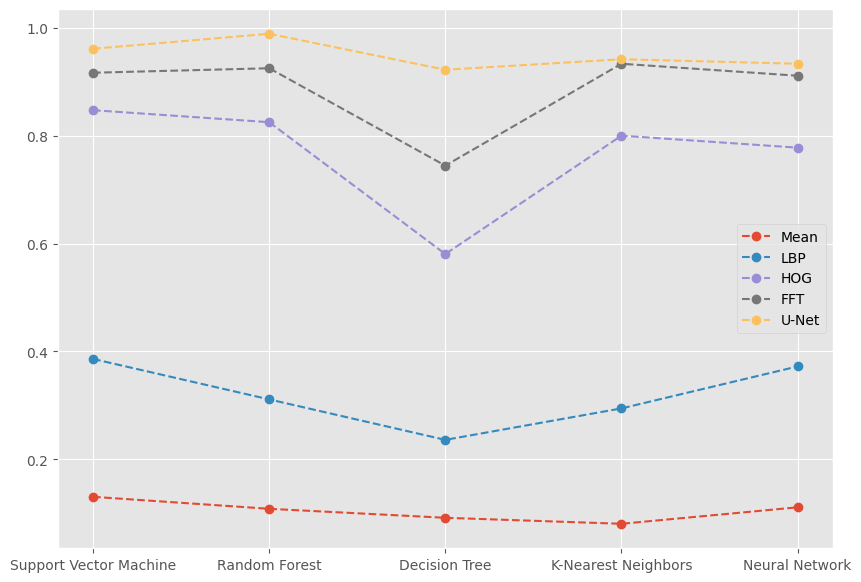

In [35]:
plot_standard(accuracy_df)

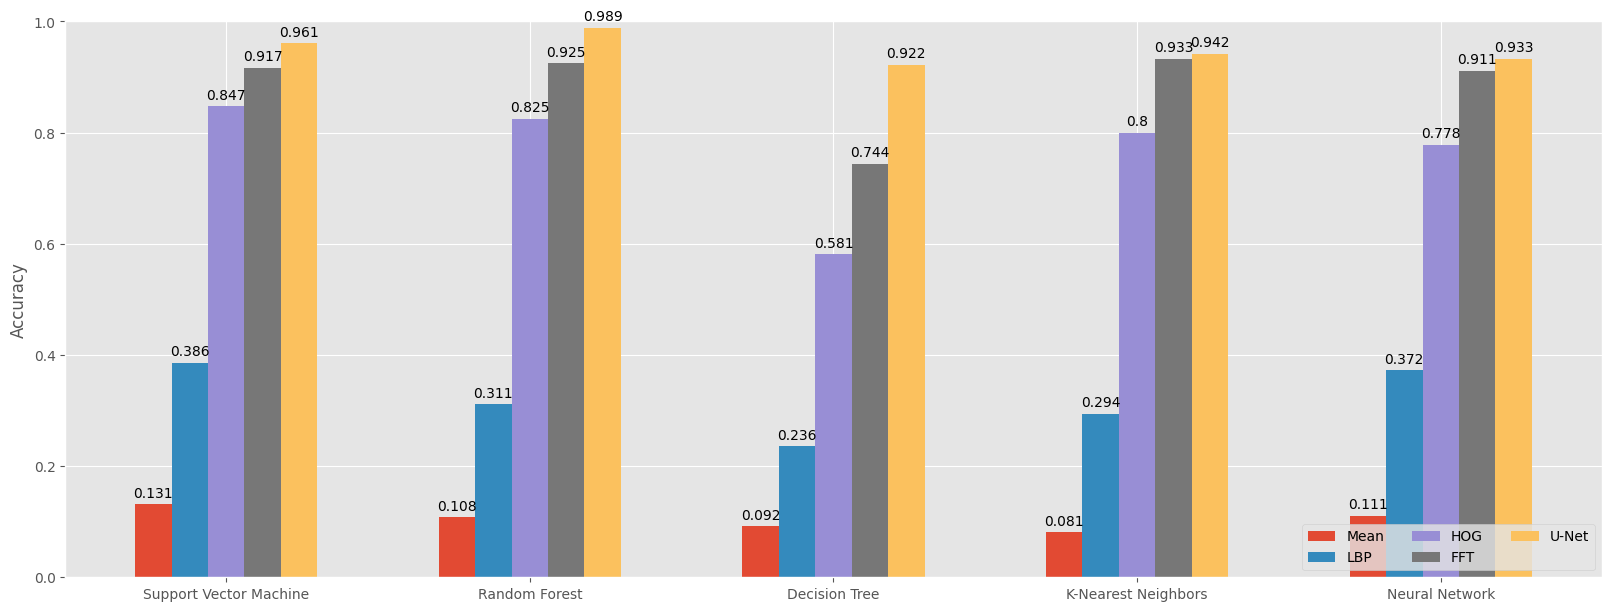

In [42]:
plot_bar(accuracy_df)